# Training

This notebook loads the ETL data and trains the LSTM. 

In [1]:
!mamba install -y numpy==1.19


                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        mamba (0.8.0) supported by @QuantStack

        GitHub:  https://github.com/mamba-org/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████████████████████████


Looking for: ['numpy==1.19']

conda-forge/linux-64     Using cache
conda-forge/noarch       Using cache
Transacti

In [1]:
# %load_ext lab_black

%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import os.path

import fsspec
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [7]:
mapper = fsspec.get_mapper(f'gs://carbonplan-scratch/metml/etl/x_train.zarr')
x_train = xr.open_zarr(mapper, consolidated=True)['x'].load()

mapper = fsspec.get_mapper(f'gs://carbonplan-scratch/metml/etl/x_val.zarr')
x_val = xr.open_zarr(mapper, consolidated=True)['x'].load()

mapper = fsspec.get_mapper(f'gs://carbonplan-scratch/metml/etl/y_train.zarr')
y_train = xr.open_zarr(mapper, consolidated=True)['y'].load()

mapper = fsspec.get_mapper(f'gs://carbonplan-scratch/metml/etl/y_val.zarr')
y_val = xr.open_zarr(mapper, consolidated=True)['y'].load()
x_train

<xarray.DataArray 'x' (samples: 350157, lookback: 90, features: 6)>
array([[[-7.82947428e+01,  1.13775274e+00,  6.67522389e-01,
          1.00000000e+00, -5.51424579e-01,  1.00129478e-01],
        [-7.82947428e+01,  1.03076599e+00,  9.24415958e-01,
          9.99852042e-01, -5.51424579e-01,  1.00129478e-01],
        [-7.82947428e+01,  9.67863797e-01,  1.25060845e+00,
          9.99408212e-01, -5.51424579e-01,  1.00129478e-01],
        ...,
        [-7.82947428e+01,  1.49466970e+00,  1.52676504e+00,
          7.41174252e-02, -5.51424579e-01,  1.00129478e-01],
        [-7.82947428e+01,  1.38220552e+00,  1.20089227e+00,
          5.69521960e-02, -5.51424579e-01,  1.00129478e-01],
        [-7.82947428e+01,  1.02873404e+00,  8.18589236e-01,
          3.97701138e-02, -5.51424579e-01,  1.00129478e-01]],

       [[-7.82947428e+01,  1.03076599e+00,  9.24415958e-01,
          9.99852042e-01, -5.51424579e-01,  1.00129478e-01],
        [-7.82947428e+01,  9.67863797e-01,  1.25060845e+00,
          9.99408212e-01, -5.51424579e-01,  1.00129478e-01],
        [-7.82947428e+01,  1.30728829e+00,  1.51717349e+00,
          9.98668640e-01, -5.51424579e-01,  1.00129478e-01],
...
        [-7.82947428e+01,  1.15604031e+00,  9.77169460e-01,
          9.97328632e-01, -2.66191770e-01,  1.58933966e-01],
        [-7.82947428e+01,  1.17079406e+00,  7.31386098e-01,
          9.98437562e-01, -2.66191770e-01,  1.58933966e-01],
        [-7.82947428e+01,  1.20789929e+00,  9.03794135e-01,
          9.99251037e-01, -2.66191770e-01,  1.58933966e-01]],

       [[-7.82947428e+01,  1.37478447e+00,  1.19945353e+00,
          1.82765577e-02, -2.66191770e-01,  1.58933966e-01],
        [-7.82947428e+01,  1.32230708e+00,  1.26419647e+00,
          3.54725558e-02, -2.66191770e-01,  1.58933966e-01],
        [-7.82947428e+01,  1.31709467e+00,  1.50318582e+00,
          5.26580569e-02, -2.66191770e-01,  1.58933966e-01],
        ...,
        [-7.82947428e+01,  1.17079406e+00,  7.31386098e-01,
          9.98437562e-01, -2.66191770e-01,  1.58933966e-01],
        [-7.82947428e+01,  1.20789929e+00,  9.03794135e-01,
          9.99251037e-01, -2.66191770e-01,  1.58933966e-01],
        [-7.82947428e+01,  1.23060415e+00,  7.79743475e-01,
          9.99768819e-01, -2.66191770e-01,  1.58933966e-01]]])
Coordinates:
  * features  (features) <U7 'P' 't_min' 't_max' 't' 'lat' 'elev'
  * lookback  (lookback) int64 -89 -88 -87 -86 -85 -84 -83 ... -5 -4 -3 -2 -1 0
Dimensions without coordinates: samples

In [5]:
xdims = dict(zip(x_train.dims, x_train.shape))
ydims = dict(zip(y_train.dims, y_train.shape))
print(xdims, ydims)

{'samples': 350157, 'lookback': 90, 'features': 6} {'samples': 350157, 'features': 4}


In [7]:
input_shape = (xdims["lookback"], xdims["features"])
print(input_shape)

(90, 6)


In [8]:
from tensorflow.keras import backend

# root mean squared error (rmse) for regression (only for Keras tensors)
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))


# mean squared error (mse) for regression  (only for Keras tensors)
def mse(y_true, y_pred):
    return backend.mean(backend.square(y_pred - y_true), axis=-1)


# coefficient of determination (R^2) for regression  (only for Keras tensors)
def r_square(y_true, y_pred):
    SS_res = backend.sum(backend.square(y_true - y_pred))
    SS_tot = backend.sum(backend.square(y_true - backend.mean(y_true)))
    return 1 - SS_res / (SS_tot + backend.epsilon())


def bias(y_true, y_pred):
    return backend.mean(y_pred) - backend.mean(y_true)


metrics = [rmse, mse, r_square, bias]
# metrics = []

def make_model_1(var, ydims=None):
    # design network
    name = f"1_layer_lstm_{var}"
    model = Sequential(name=name)
    model.add(LSTM(20, input_shape=input_shape, use_bias=True))
    model.add(Dense(ydims["features"]))
    model.compile(loss="mean_squared_error", optimizer="adam", metrics=metrics)
    return model


def make_model_2(var, ydims=None):
    # design network
    name = f"2_layer_lstm_{var}"
    model = Sequential(name=name)
    model.add(LSTM(20, input_shape=input_shape, use_bias=True, return_sequences=True))
    model.add(LSTM(20))
    model.add(Dense(ydims["features"]))
    model.compile(loss="mean_squared_error", optimizer="adam", metrics=metrics)
    return model


def make_model_3(var, ydims=None):
    # design network
    name = f"3_layer_lstm_{var}"
    model = Sequential(name=name)
    model.add(LSTM(20, input_shape=input_shape, use_bias=True, return_sequences=True))
    model.add(LSTM(20, return_sequences=True))
    model.add(LSTM(20))
    model.add(Dense(ydims["features"]))
    model.compile(loss="mean_squared_error", optimizer="adam", metrics=metrics)
    return model


def make_model_4(var, ydims=None):
    # design network
    name = f"3_layer_lstm_wide_{var}"
    model = Sequential(name=name)
    model.add(LSTM(40, input_shape=input_shape, use_bias=True, return_sequences=True))
    model.add(LSTM(40, return_sequences=True))
    model.add(LSTM(40))
    model.add(Dense(ydims["features"]))
    model.compile(loss="mean_squared_error", optimizer="adam", metrics=metrics)
    return model

In [12]:
# train the model
# history = {}
# for batch_size in [128, 512, 2048, 8192, 16384]:
#     model = make_model_1('SW_IN_F')
#     history[batch_size] = model.fit(
#         x_train.values, y_train.values,
#         validation_data=(x_val.values, y_val.values),
#         batch_size=batch_size, epochs=30,
#         shuffle=True, callbacks=callbacks
#     )

# plt.figure(figsize=(12, 12))
# # plot training history
# for batch, h in history.items():
# #     plt.plot(h.history['loss'], label=f'train-{batch}')
#     plt.plot(h.history['val_loss'], label=f'test-{batch}')
# plt.yscale('log')
# plt.xscale('log')
# plt.legend()

# based on this, I'm using the batch_size of 512 for now

In [18]:
# y_val[:100].plot.line(x="samples")

In [14]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)

Name: /physical_device:GPU:0   Type: GPU


In [35]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

batch_size = 512
history = {}


def make_callbacks(name):
    mc = ModelCheckpoint(
        f"best_{name}.h5",
        monitor="val_loss",
        mode="min",
        verbose=0,
        save_best_only=True,
    )
    es = EarlyStopping(monitor="val_loss", mode="min", verbose=0, patience=20)
    return [es, mc]

for var in y_train.features.values:
    print(var)
    yt = y_train.sel(features=var)
    yv = y_val.sel(features=var)
    ydims = dict(zip(yt.dims, yt.shape))
    if 'features' not in ydims:
        ydims['features'] = 1
    
    for model in [make_model_1(var, ydims), make_model_2(var, ydims), make_model_3(var, ydims), make_model_4(var, ydims)]:
#     for model in [make_model_1(var, ydims)]:
        model.summary()
        history[model.name] = model.fit(
            x_train.values,
            yt.values,
            validation_data=(x_val.values, yv.values,),
            batch_size=batch_size,
            epochs=500,
            shuffle=True,
            callbacks=make_callbacks(model.name),
        )
        

SW_IN_F
Model: "1_layer_lstm_SW_IN_F"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 20)                2160      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 21        
Total params: 2,181
Trainable params: 2,181
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
684/684 [==============================] - 10s 12ms/step - loss: 0.0509 - rmse: 0.1596 - mse: 0.0509 - r_square: 0.0658 - bias: -0.0125 - val_loss: 0.0146 - val_rmse: 0.0930 - val_mse: 0.0146 - val_r_square: 0.6382 - val_bias: 0.0059
Epoch 2/500
684/684 [==============================] - 7s 10ms/step - loss: 0.0132 - rmse: 0.0883 - mse: 0.0132 - r_square: 0.7583 - bias: -3.3961e-04 - val_loss: 0.0115 - val_rmse: 0.0812 - val_mse: 0.0115 - val_r_square: 0.7231 - val_bias: 0.0109
Epo

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



684/684 [==============================] - 23s 34ms/step - loss: 0.0086 - rmse: 0.0695 - mse: 0.0086 - r_square: 0.8418 - bias: -8.2697e-05 - val_loss: 0.0086 - val_rmse: 0.0683 - val_mse: 0.0086 - val_r_square: 0.7925 - val_bias: -0.0025
Epoch 8/500
684/684 [==============================] - 23s 34ms/step - loss: 0.0084 - rmse: 0.0687 - mse: 0.0084 - r_square: 0.8449 - bias: -4.3657e-06 - val_loss: 0.0087 - val_rmse: 0.0698 - val_mse: 0.0087 - val_r_square: 0.7908 - val_bias: 0.0074
Epoch 9/500
684/684 [==============================] - 23s 34ms/step - loss: 0.0083 - rmse: 0.0680 - mse: 0.0083 - r_square: 0.8475 - bias: -9.9027e-05 - val_loss: 0.0090 - val_rmse: 0.0698 - val_mse: 0.0090 - val_r_square: 0.7808 - val_bias: 0.0232
Epoch 10/500
684/684 [==============================] - 23s 34ms/step - loss: 0.0082 - rmse: 0.0675 - mse: 0.0082 - r_square: 0.8484 - bias: 7.7156e-05 - val_loss: 0.0087 - val_rmse: 0.0695 - val_mse: 0.0087 - val_r_square: 0.7883 - val_bias: -0.0045
Epoch 11/5

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



684/684 [==============================] - 23s 34ms/step - loss: 0.0074 - rmse: 0.0633 - mse: 0.0074 - r_square: 0.8640 - bias: -7.7351e-05 - val_loss: 0.0079 - val_rmse: 0.0644 - val_mse: 0.0079 - val_r_square: 0.8089 - val_bias: 0.0055
Epoch 26/500
684/684 [==============================] - 23s 34ms/step - loss: 0.0074 - rmse: 0.0630 - mse: 0.0074 - r_square: 0.8643 - bias: -1.7528e-04 - val_loss: 0.0079 - val_rmse: 0.0645 - val_mse: 0.0079 - val_r_square: 0.8058 - val_bias: -0.0037
Epoch 27/500
684/684 [==============================] - 23s 34ms/step - loss: 0.0074 - rmse: 0.0630 - mse: 0.0074 - r_square: 0.8648 - bias: -3.6917e-05 - val_loss: 0.0080 - val_rmse: 0.0646 - val_mse: 0.0080 - val_r_square: 0.8050 - val_bias: 0.0093
Epoch 28/500
684/684 [==============================] - 23s 34ms/step - loss: 0.0073 - rmse: 0.0628 - mse: 0.0073 - r_square: 0.8658 - bias: 7.8505e-05 - val_loss: 0.0079 - val_rmse: 0.0642 - val_mse: 0.0079 - val_r_square: 0.8069 - val_bias: 0.0058
Epoch 29/

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



684/684 [==============================] - 23s 34ms/step - loss: 0.0069 - rmse: 0.0609 - mse: 0.0069 - r_square: 0.8736 - bias: -7.4472e-05 - val_loss: 0.0080 - val_rmse: 0.0647 - val_mse: 0.0080 - val_r_square: 0.8032 - val_bias: -8.5908e-04
Epoch 43/500
684/684 [==============================] - 23s 34ms/step - loss: 0.0069 - rmse: 0.0610 - mse: 0.0069 - r_square: 0.8730 - bias: -9.4049e-05 - val_loss: 0.0080 - val_rmse: 0.0653 - val_mse: 0.0080 - val_r_square: 0.8033 - val_bias: 0.0016
Epoch 44/500
684/684 [==============================] - 23s 34ms/step - loss: 0.0069 - rmse: 0.0608 - mse: 0.0069 - r_square: 0.8743 - bias: 8.2476e-05 - val_loss: 0.0080 - val_rmse: 0.0649 - val_mse: 0.0080 - val_r_square: 0.8039 - val_bias: 0.0024
Epoch 45/500
684/684 [==============================] - 23s 34ms/step - loss: 0.0068 - rmse: 0.0604 - mse: 0.0068 - r_square: 0.8751 - bias: 1.0307e-04 - val_loss: 0.0078 - val_rmse: 0.0643 - val_mse: 0.0078 - val_r_square: 0.8086 - val_bias: -9.0378e-04
E

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



684/684 [==============================] - 23s 34ms/step - loss: 0.0066 - rmse: 0.0594 - mse: 0.0066 - r_square: 0.8793 - bias: -1.1203e-04 - val_loss: 0.0080 - val_rmse: 0.0645 - val_mse: 0.0080 - val_r_square: 0.8067 - val_bias: 0.0058
Epoch 60/500
684/684 [==============================] - 23s 34ms/step - loss: 0.0066 - rmse: 0.0594 - mse: 0.0066 - r_square: 0.8798 - bias: 1.1761e-04 - val_loss: 0.0079 - val_rmse: 0.0642 - val_mse: 0.0079 - val_r_square: 0.8077 - val_bias: 7.4236e-04
Epoch 61/500
684/684 [==============================] - 23s 34ms/step - loss: 0.0066 - rmse: 0.0594 - mse: 0.0066 - r_square: 0.8793 - bias: -3.1857e-05 - val_loss: 0.0080 - val_rmse: 0.0649 - val_mse: 0.0080 - val_r_square: 0.8041 - val_bias: 0.0037
Epoch 62/500
684/684 [==============================] - 23s 34ms/step - loss: 0.0065 - rmse: 0.0591 - mse: 0.0065 - r_square: 0.8809 - bias: 1.4585e-04 - val_loss: 0.0083 - val_rmse: 0.0661 - val_mse: 0.0083 - val_r_square: 0.7946 - val_bias: 0.0070
Epoch 6

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



684/684 [==============================] - 12s 17ms/step - loss: 0.0038 - rmse: 0.0484 - mse: 0.0038 - r_square: 0.8377 - bias: 5.8239e-05 - val_loss: 0.0040 - val_rmse: 0.0491 - val_mse: 0.0040 - val_r_square: 0.6037 - val_bias: -0.0024
Epoch 7/500
684/684 [==============================] - 12s 17ms/step - loss: 0.0037 - rmse: 0.0480 - mse: 0.0037 - r_square: 0.8404 - bias: 3.5105e-06 - val_loss: 0.0040 - val_rmse: 0.0488 - val_mse: 0.0040 - val_r_square: 0.6079 - val_bias: 9.9906e-04
Epoch 8/500
684/684 [==============================] - 12s 17ms/step - loss: 0.0037 - rmse: 0.0475 - mse: 0.0037 - r_square: 0.8432 - bias: -5.4147e-06 - val_loss: 0.0039 - val_rmse: 0.0484 - val_mse: 0.0039 - val_r_square: 0.6054 - val_bias: -0.0017
Epoch 9/500
684/684 [==============================] - 12s 17ms/step - loss: 0.0036 - rmse: 0.0471 - mse: 0.0036 - r_square: 0.8459 - bias: 1.3195e-05 - val_loss: 0.0039 - val_rmse: 0.0485 - val_mse: 0.0039 - val_r_square: 0.6078 - val_bias: -1.5935e-04
Epoc

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



684/684 [==============================] - 12s 18ms/step - loss: 0.0028 - rmse: 0.0413 - mse: 0.0028 - r_square: 0.8782 - bias: 2.5020e-05 - val_loss: 0.0037 - val_rmse: 0.0469 - val_mse: 0.0037 - val_r_square: 0.6174 - val_bias: -0.0042
Epoch 40/500
684/684 [==============================] - 13s 19ms/step - loss: 0.0028 - rmse: 0.0413 - mse: 0.0028 - r_square: 0.8787 - bias: 5.2767e-05 - val_loss: 0.0038 - val_rmse: 0.0475 - val_mse: 0.0038 - val_r_square: 0.6101 - val_bias: -0.0088
Epoch 41/500
684/684 [==============================] - 12s 17ms/step - loss: 0.0028 - rmse: 0.0412 - mse: 0.0028 - r_square: 0.8791 - bias: -5.1525e-05 - val_loss: 0.0039 - val_rmse: 0.0478 - val_mse: 0.0039 - val_r_square: 0.5941 - val_bias: -0.0063
Epoch 42/500
684/684 [==============================] - 12s 17ms/step - loss: 0.0028 - rmse: 0.0412 - mse: 0.0028 - r_square: 0.8792 - bias: -4.0882e-06 - val_loss: 0.0038 - val_rmse: 0.0473 - val_mse: 0.0038 - val_r_square: 0.5971 - val_bias: -0.0104
Epoch 4

In [36]:
history

{'1_layer_lstm_SW_IN_F': <tensorflow.python.keras.callbacks.History at 0x7fa6f5f4f3d0>,
 '2_layer_lstm_SW_IN_F': <tensorflow.python.keras.callbacks.History at 0x7fa6f5a43700>,
 '3_layer_lstm_SW_IN_F': <tensorflow.python.keras.callbacks.History at 0x7fa710043dc0>,
 '3_layer_lstm_wide_SW_IN_F': <tensorflow.python.keras.callbacks.History at 0x7fa6f0f2c910>,
 '1_layer_lstm_LW_IN_F': <tensorflow.python.keras.callbacks.History at 0x7fa694401df0>,
 '2_layer_lstm_LW_IN_F': <tensorflow.python.keras.callbacks.History at 0x7fa66260fd30>,
 '3_layer_lstm_LW_IN_F': <tensorflow.python.keras.callbacks.History at 0x7fa66054bac0>,
 '3_layer_lstm_wide_LW_IN_F': <tensorflow.python.keras.callbacks.History at 0x7fa694e6fee0>,
 '1_layer_lstm_PA_F': <tensorflow.python.keras.callbacks.History at 0x7fa6383d4eb0>,
 '2_layer_lstm_PA_F': <tensorflow.python.keras.callbacks.History at 0x7fa637eceb80>,
 '3_layer_lstm_PA_F': <tensorflow.python.keras.callbacks.History at 0x7fa635fd6e50>,
 '3_layer_lstm_wide_PA_F': <ten

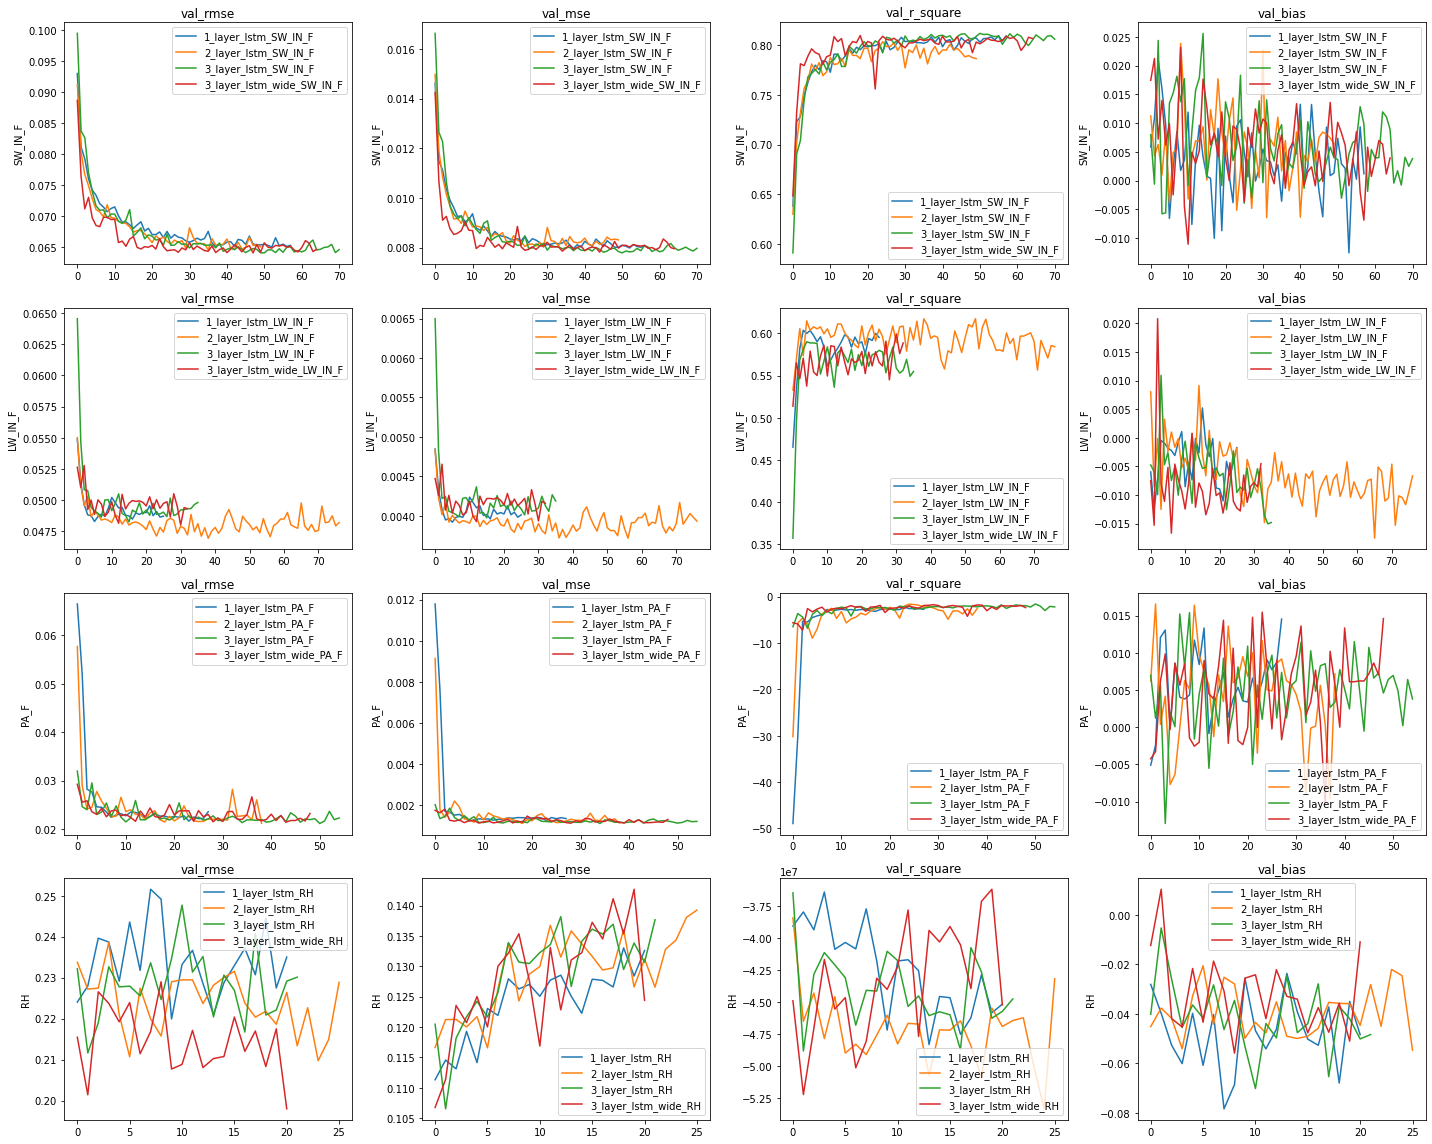

In [37]:
scores = [
    "val_rmse",
    "val_mse",  # same as val_loss 
    "val_r_square",
    "val_bias",
]

fig, axes = plt.subplots(ncols=len(scores), nrows=4, figsize=(20, 16))
for i, var in enumerate(y_train.features.values):
    for j, score in enumerate(scores):
        # plot training history
        plt.sca(axes[i, j])
        plt.title(score)
        for model, h in history.items():
            if var in model:
                plt.plot(h.history[score], label=model)
        plt.ylabel(var)
        # plt.yscale('log')
        # plt.xscale('log')
        plt.legend()
plt.tight_layout()

In [38]:
from joblib import dump

hdump = {}

for k, v in history.items():
    hdump[k] = v.history

In [39]:
dump(hdump, "train_history.joblib")

['train_history.joblib']

In [3]:
from joblib import load

In [4]:
hdump = load("train_history.joblib")

In [5]:
hdump['1_layer_lstm_SW_IN_F'].keys()

dict_keys(['loss', 'rmse', 'mse', 'r_square', 'bias', 'val_loss', 'val_rmse', 'val_mse', 'val_r_square', 'val_bias'])

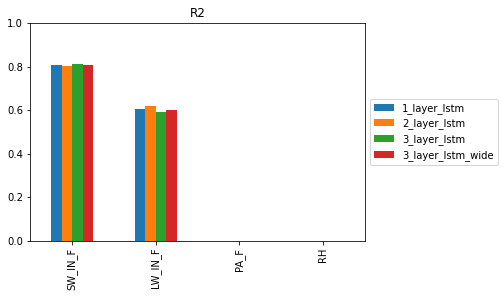

In [8]:
scores_df = pd.DataFrame()
for var in y_train.features.values:
    var_scores = {}
    for model, scores in hdump.items():
        if var in model:
            key = model.replace("_" + var, "")
            var_scores[key] = max(scores["val_r_square"])
    scores_df[var] = pd.Series(var_scores)

scores_df.T.plot.bar()
plt.title('R2')
plt.ylim(0, 1)
plt.legend(loc="center left", bbox_to_anchor=(1.0, 0.5))

In [9]:
scores_df

,SW_IN_F,LW_IN_F,PA_F,RH
1_layer_lstm,0.809458,0.603771,-2.244030,-36429704.0
2_layer_lstm,0.803471,0.617477,-1.603146,-38447792.0
3_layer_lstm,0.811817,0.590161,-1.571014,-36494100.0
3_layer_lstm_wide,0.809619,0.599446,-1.725999,-36217132.0


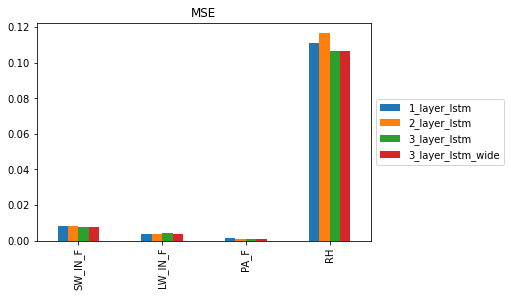

In [54]:
scores_df = pd.DataFrame()
for var in y_train.features.values:
    var_scores = {}
    for model, scores in hdump.items():
        if var in model:
            key = model.replace("_" + var, "")
            var_scores[key] = min(scores["val_mse"])
    scores_df[var] = pd.Series(var_scores)

scores_df.T.plot.bar()
plt.title('MSE')
plt.legend(loc="center left", bbox_to_anchor=(1.0, 0.5))

Based on this analysis, it seems like the 3_layer_lstm_wide model is performing best for all four variables. We'll go with that for now.